In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(101)

num_pos, num_neg = 40, 20
num_workers = 0
num_epochs = 1
script = False


hdu_list = fits.open('35.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_pos)
images_pos = hdu_list[1].data[idx,:] 
print(images_pos.shape)
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
labels_pos = np.zeros(num_pos, dtype = np.int64)

hdu_list = fits.open('negative_redmagic.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg1 = hdu_list[1].data[idx,:] 
images_neg1 = images_neg1[:,0:3,:,:]
labels_neg1 = np.ones(num_neg, dtype = np.int64)
print(images_neg1.shape)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg1 = np.full((num_neg, num_columns-1), 0)
data_neg1 = pd.DataFrame(data_neg1, columns=['zl/z1', 'm', 'iso', 'E', 'Magni 1'])
last_column = ['NEG']*num_neg
data_neg1['ID'] = last_column

hdu_list = fits.open('negative_othergalaxies.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg2 = hdu_list[1].data[idx,:] 
images_neg2 = images_neg2[:,0:3,:,:]
labels_neg2 = np.ones(num_neg, dtype = np.int64)
print(images_neg2.shape)
#Data for negatives, all null
data_neg2 = data_neg1

images_dataset = np.concatenate((images_pos, images_neg1, images_neg2)).astype(np.float32)
data_dataset = pd.concat([data_pos, data_neg1, data_neg2], axis=0).reset_index(drop=True)
labels_dataset = np.concatenate((labels_pos, labels_neg1, labels_neg2), dtype = np.int64)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images_dataset.shape)
print(images_dataset.dtype)

(40, 3, 45, 45)
(20, 3, 45, 45)
(20, 3, 45, 45)
(80, 3, 45, 45)
float32


In [6]:
train_dataset, other_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.3, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 56, len test dataset: 12


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)

In [8]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [9]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            accuracy = sum(output.argmax(dim=1) == target)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                accuracy = sum(output.argmax(dim=1) == target)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [10]:
model = ViTBase16(n_classes=2, pretrained=True)

# Start training processes
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [11]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc
    """
    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }"""

In [12]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)
    

In [13]:
name_model = 'other.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/3 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.04374045133590698, ACCURACY: 0.6071428656578064

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.0453215092420578, ACCURACY: 0.5833333134651184



In [14]:
print('Maximum memory usage: %s' % max(mem_usage))

Maximum memory usage: 3273.0078125


In [15]:
name = 'other.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))

Maximum validation accuracy: 58.33%


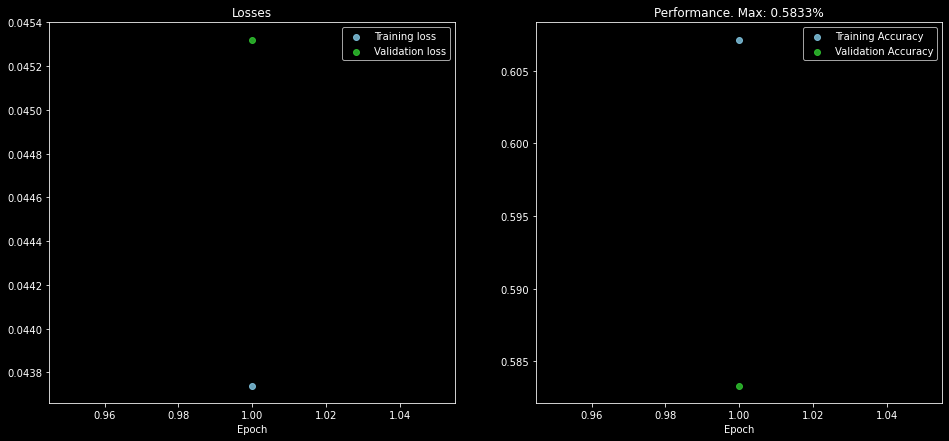

In [16]:
plot_performance(model)

In [17]:
def testing_analysis(prob_lim, test_loader):
    right_pos_img, wrong_pos_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    right_neg_img, wrong_neg_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    columns = ['zl/z1', 'm', 'iso', 'E', 'Magni 1', 'ID', 'Prob']
    prob_list = []
    right_pos, wrong_pos = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)
    right_neg, wrong_neg = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)

    for i_batch, sample in enumerate(tqdm(test_loader)):
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
    
        #if(i_batch <= 50): continue
        output = model(sample_image)
        predicted = output.argmax(dim=1).item()
        my_df = pd.DataFrame.from_dict(sample_data)
    
        prob = nn.Softmax(dim=1)(output)
        prob = prob[:,0].detach().numpy()[0]
        prob_list.append(prob)
    
        predicted = 0 if prob >= prob_lim else 1
    
        new_df = pd.DataFrame.from_dict(sample_data)
        new_df['Prob'] = prob
    
        if(sample_label.item() == 0 and predicted == 0):
            right_pos_img = np.append(right_pos_img, [np.array(sample_img[0])], axis = 0)
            right_pos = right_pos.append(new_df, ignore_index=True)
        elif(sample_label.item() == 0 and predicted == 1):
            wrong_pos_img = np.append(wrong_pos_img, [np.array(sample_img[0])], axis = 0)
            wrong_pos = wrong_pos.append(new_df, ignore_index=True)
        if(sample_label.item() == 1 and predicted == 1): 
            right_neg_img = np.append(right_neg_img, [np.array(sample_img[0])], axis = 0)
            right_neg = right_neg.append(new_df, ignore_index=True)
        elif(sample_label.item() == 1 and predicted == 0): 
            wrong_neg_img = np.append(wrong_neg_img, [np.array(sample_img[0])], axis = 0)
            wrong_neg = wrong_neg.append(new_df, ignore_index=True)
    
    
    right_pos_img = np.delete(right_pos_img, 0, axis = 0)
    wrong_pos_img = np.delete(wrong_pos_img, 0, axis = 0)
    right_neg_img = np.delete(right_neg_img, 0, axis = 0)
    wrong_neg_img = np.delete(wrong_neg_img, 0, axis = 0)
    
    FPR = len(wrong_neg_img)/(len(wrong_neg_img) + len(right_neg_img))*100
    TPR = len(right_pos_img)/(len(right_pos_img) + len(wrong_pos_img))*100
    
    images = [right_pos_img, wrong_pos_img, right_neg_img, wrong_neg_img]
    data = [right_pos, wrong_pos, right_neg, wrong_neg]
    rates = [FPR, TPR]
    
    return(images, data, rates, prob_list)


In [18]:
prob_lim = 0.95
images, data, rates, prob_list = testing_analysis(prob_lim, test_loader)
right_pos_img, wrong_pos_img, right_neg_img, wrong_neg_img = images[0], images[1], images[2], images[3]
right_pos, wrong_pos, right_neg, wrong_neg = data[0], data[1], data[2], data[3]
FPR, TPR = rates[0], rates[1]

  0%|          | 0/12 [00:00<?, ?it/s]

In [19]:
def prob_distribution(prob_list):
    plt.figure(figsize=(10,6))
    plt.title('Probability labeled as Positive')
    plt.hist(prob_list, 100, color = "skyblue")
    if(script):
        plt.savefig('Prob_Pos Distribution.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show()

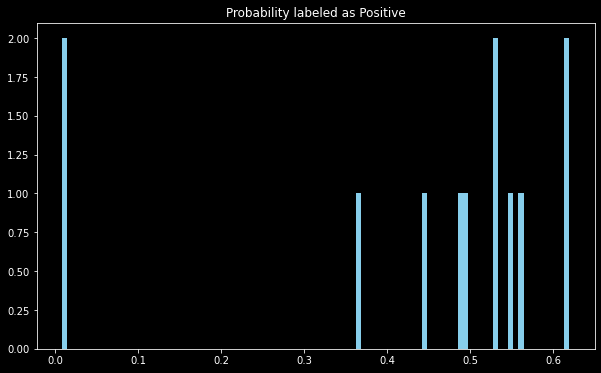

In [20]:
prob_distribution(prob_list)

In [21]:
print('Right positives: ' + str(right_pos_img.shape))
print('Wrong positives: ' + str(wrong_pos_img.shape))
print('Right negatives: ' + str(right_neg_img.shape))
print('Wrong negatives: ' + str(wrong_neg_img.shape))
print('Accuracy: '+ str( 100*(len(right_pos_img)+len(right_neg_img)) /len(test_dataset)) + '%')
print('True positive rate: ' + str(TPR) + '%')
print('False positive rate: ' + str(FPR) + '%')
print('Mean prob. right positives: ' + str(np.mean(right_pos['Prob'])))
print('Mean prob. wrong positives: ' + str(np.mean(wrong_pos['Prob'])))
print('Mean prob. right negatives: ' + str(np.mean(right_neg['Prob'])))
print('Mean prob. wrong negatives: ' + str(np.mean(wrong_neg['Prob'])))

Right positives: (0, 3, 45, 45)
Wrong positives: (6, 3, 45, 45)
Right negatives: (6, 3, 45, 45)
Wrong negatives: (0, 3, 45, 45)
Accuracy: 50.0%
True positive rate: 0.0%
False positive rate: 0.0%
Mean prob. right positives: nan
Mean prob. wrong positives: 0.5229271054267883
Mean prob. right negatives: 0.3471449613571167
Mean prob. wrong negatives: nan


In [22]:
def make_plot_all(objects, title, prob_list):
    #print(title)
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                plt.title(prob_list[i+j])
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            if(script):
                plt.savefig(title+'_'+str(i+j), bbox_inches='tight')
                plt.close()
            else: 
                plt.show()
                

In [23]:
make_plot_all(wrong_neg_img, 'Wrong negatives', wrong_neg['Prob'])

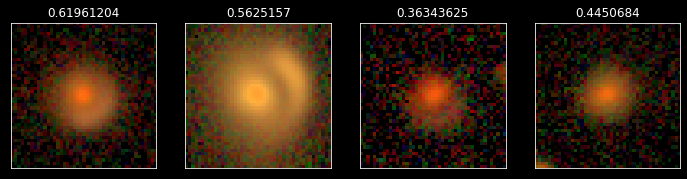

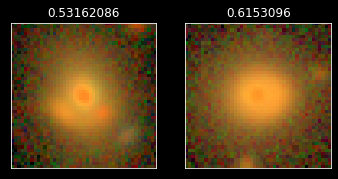

In [24]:
make_plot_all(wrong_pos_img, 'Wrong positives', wrong_pos['Prob'])

In [25]:
make_plot_all(right_pos_img, 'Right positives', right_pos['Prob'])

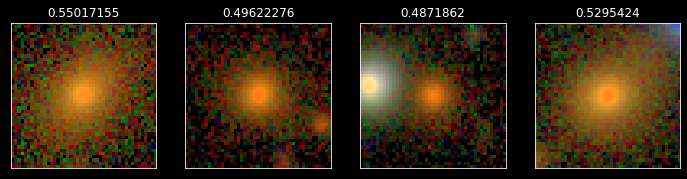

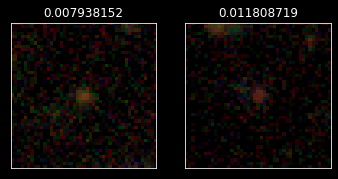

In [26]:
make_plot_all(right_neg_img, 'Right negatives', right_neg['Prob'])

In [27]:
def ROC_curve(num_points):
    prob_lim = np.linspace(0, 1., num_points)
    FPR_list, TPR_list = [], []
    for prob in prob_lim:
        images, data, rates, prob_list = testing_analysis(prob, test_loader)
        FPR, TPR = rates[0], rates[1]
        FPR_list.append(FPR)
        TPR_list.append(TPR)
        print(prob, FPR, TPR)
    plt.figure(figsize=(6,6))
    plt.plot(FPR_list, TPR_list, 'o')
    if(script):
        plt.savefig('ROC curve', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [28]:
#ROC_curve(5)

In [29]:
"""
path = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn/Y6_catalog_files/'
filename = 'DES0456-2458.fits'
hdu_list = fits.open(path + filename)
search_ids = pd.DataFrame(hdu_list[1].data)
search_images = hdu_list[2].data
search_images.dtype = np.float16
search_labels = 2*np.ones(len(search_ids), dtype = np.int64)

search_dataset = ImageDataset(search_images, search_ids, search_labels, transform=transform)
search_loader = torch.utils.data.DataLoader(dataset=search_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
"""

"\npath = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn/Y6_catalog_files/'\nfilename = 'DES0456-2458.fits'\nhdu_list = fits.open(path + filename)\nsearch_ids = pd.DataFrame(hdu_list[1].data)\nsearch_images = hdu_list[2].data\nsearch_images.dtype = np.float16\nsearch_labels = 2*np.ones(len(search_ids), dtype = np.int64)\n\nsearch_dataset = ImageDataset(search_images, search_ids, search_labels, transform=transform)\nsearch_loader = torch.utils.data.DataLoader(dataset=search_dataset, batch_size=1, num_workers=num_workers, shuffle=True)\n"

In [30]:
def search_tile(search_loader, prob_lim):
    positives = np.zeros((1,4,46,46))
    columns = ['COADD_OBJECT_ID']
    positive_ids = pd.DataFrame(columns=columns)
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==5000): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
        predicted = output.argmax(dim=1).item()
    
        prob = nn.Softmax(dim=1)(output)
        prob = prob[:,0].detach().numpy()[0]
    
        predicted = 0 if prob >= prob_lim else 1
    
        if(predicted == 0):
            print('Positive!')
            positives = np.append(positives, [np.array(sample_img[0])], axis = 0)
            positive_ids = positive_ids.append(pd.DataFrame.from_dict(sample_data), ignore_index=True)
    
    positives = np.delete(positives, 0, axis = 0)
    return(positives, positive_ids)

In [31]:
#positives, positive_ids = search_tile(search_loader, prob_lim)

In [32]:
#positive_ids.to_csv(filename[:-5] + '_pos.fit')